### London Social Infrastructure Recipe

##### Using OSM Data the recipe aims at counting the Health Count, Education Count and Civic Count amenities

##### About Social Infrastructure

###### Our social infrastructure index uses OpenStreetMap data to demonstrate how many items of social infrastructure are tagged on 
###### OpenStreetMap within each Lower Super Output Area. We have segmented social infrastructure into three categories:

##### Education tags include:

    - School
    - Library
    - University
    - College
    - Kindergarten

##### Heath tags include:

    - Clinic
    - Dentist
    - Doctors
    - Hospital
    - Pharmacy

##### Civic tags include:

    - courthouse
    - coworking_space
    - bench
    - fire_station
    - place_of_worship
    - police
    - post-box
    - post_office
    - public_bath
    - recycling
    - town_hall
    - waste_disposal

###### A value of 10 suggests that there are 10 social amenities in that LSOA. 
###### This value represents the summation of each of the categories (Education, Health and Civic) respectively.

In [1]:
import os
from pathlib import Path

home_dir = str(Path.home())
tdc = os.path.join(home_dir, 'Desktop/python_library_dc/digital-connector-python')
digital_connector = os.path.join(home_dir, 'Desktop/UptodateProject/TomboloDigitalConnector')
os.chdir(tdc)

#### Import classes

##### Here we are importing different components required to build the recipe

In [37]:
from recipe import Subject, Dataset, Geo_Match_Rule, Match_Rule, Datasource, GeographicAggregationField, AttributeMatcherField, ConstantField, AttributeMatcher, ListArithmeticField

#### Creating Main Subject

The section below creates a Match Rule which means it will only search for local authorities of London
and has a geo relation which is to ensure that only those areas which are within london gets included

In [46]:
match_rule_ = Match_Rule(attribute_to_match_on='label', pattern='E0900%')
inner_subject = Subject(subject_type_label='localAuthority', provider_label='uk.gov.ons', 
                       match_rule=match_rule_)
geo_match_ = Geo_Match_Rule(geo_relation='within', subjects=[inner_subject])
main_subject = Subject(subject_type_label='lsoa', provider_label='uk.gov.ons', 
                      geo_match_rule=geo_match_)

#### Creating Datasources

Data sources are a way to tell which importers do you want to use, importers downloads data and cleans it before putting it in 
database and make it ready for use.

In this recipe we are using OaImporter and OSMImporter to download data, 
OaImporter is downloading data for ```lsoa``` and ```localAuthority```
OSMImporter is donwloading data for ```europe/great-britain/england/greater-london``` for ```OSMHealth, OSMCivic, OSMEducation```


In [47]:
oa_class = 'uk.org.tombolo.importer.ons.OaImporter'
osm_class = 'uk.org.tombolo.importer.osm.OSMImporter'
geography_ = 'europe/great-britain/england/greater-london'
osm_datasource_ids = ['OSMHealth', 'OSMCivic', 'OSMEducation']
osm_datasources = []
lsoa_data = Datasource(importer_class=oa_class, datasource_id='lsoa')
la_data = Datasource(importer_class=oa_class, datasource_id='localAuthority')
osm_datasources.append(lsoa_data)
osm_datasources.append(la_data)
for datasource in osm_datasource_ids:
    osm_datasources.append(Datasource(importer_class=osm_class, datasource_id=datasource, geography_scope=[geography_]))

#### Creating Fields

Fields perform computations, based on user's need user could choose different fields e.g
```LatestValueField``` which can be used to pull the lastest value (as name suggest) of a Subject and Attribute
```TimeseriesMeanValueField``` which can be used to take mean of an Attribute value of Multiple years
and many more, please read through documentation

In this example we are using Geographic Aggregation Field along with Arthmetic Field to calculate sum of an amentity in a particular lsoa

In [49]:
constant_field = ConstantField(value='1')
geo_sub = Subject(provider_label='org.openstreetmap', subject_type_label='OSMEntity')

field_attributes = [['amenity', 'Health Count', ['clinic', 'dentist', 'doctors', 'hospital', 'pharmacy']],
                   ['amenity','Education Count', ['school', 'library', 'university', 'college', 'kindergarten']],
                   ['amenity','Civic Count', ['courthouse', 'coworking_space', 'recycling', 'fire_station', 'place_of_worship', 'police', 'post_office', 'town_hall', 'waste_disposal']]]

fields = []
for i in range(len(field_attributes)):
    attr_matcher = AttributeMatcher(provider='org.openstreetmap', label=field_attributes[i][0], 
                                   values=field_attributes[i][2])
    attr_matcher_field = AttributeMatcherField(attributes=[attr_matcher], field=constant_field, 
                                              label=field_attributes[i][0])
    geo_agg_field = GeographicAggregationField(subject=geo_sub, function='sum', 
                                               field=attr_matcher_field, label=field_attributes[i][1])
    fields.append(geo_agg_field)


In [50]:
arthmetic_field = ListArithmeticField(operation='add', fields=fields, label='Sum of civic amenities')

In [51]:
all_fields = [x for x in fields]
all_fields.append(arthmetic_field)
dataset = Dataset(subjects=[main_subject], datasources=osm_datasources, fields=all_fields)

#### Building and Running a Recipe

One can use Dataset object and call ```build_and_run``` to build and run the recipe in one single step rather making two seperate calls
However it is possible to call these methods seperately in case one wants to see the recipe first before running it.

In ```build_and_run``` user could see the recipe by making ```recipe_console_print``` option to ```true```
There are more tweaks that user could do, for complete list please go through the ```recipe.py``` file

In [52]:
dataset.build_and_run(tombolo_path=digital_connector, model_output_location=home_dir + '/london-social-infra.json', 
                     recipe_console_print=False, model_output_console_print=False)

Execution completed Successfully!!!!


#### Using and Visualizing the output

Now that we have the output we could use any library of our choice to do more computations on the output, in order to get some insights 
on the data.

Here we are using ```GeoPandas``` to first load the dataset and then visualising the first 5 rows of the dataset

Then we are plotting the dataset using ```Matplotlib``` and in the second image we are only plotting ```Sum of Civic Amenities```

In [53]:
import geopandas as gpd

In [54]:
merged_data = gpd.read_file(home_dir + '/london-social-infra.json')
merged_data.head()

,Civic Count,Sum of civic amenities,name,Health Count,label,Education Count,geometry
0,1.0,4.0,Greenwich 030E,1.0,E01033729,2.0,"POLYGON ((0.08169999999999999 51.4513, 0.0835 ..."
1,0.0,3.0,Greenwich 007G,3.0,E01033744,0.0,"POLYGON ((0.08069999999999999 51.4955, 0.08169..."
2,0.0,0.0,Greenwich 002I,0.0,E01033745,0.0,"POLYGON ((0.1081 51.5013, 0.1067 51.5002, 0.10..."
3,4.0,5.0,Greenwich 038E,1.0,E01033746,0.0,"POLYGON ((-0.0122 51.4779, -0.0124 51.4772, -0..."
4,1.0,2.0,Islington 006G,0.0,E01033494,1.0,"POLYGON ((-0.1028 51.5593, -0.1022 51.5584, -0..."


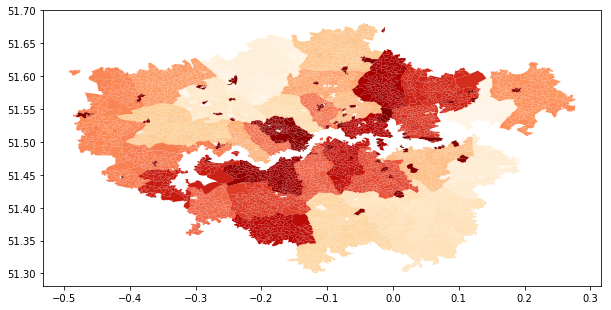

In [55]:
import matplotlib.pyplot as plt
merged_data.plot(cmap='OrRd', figsize=(10,8))

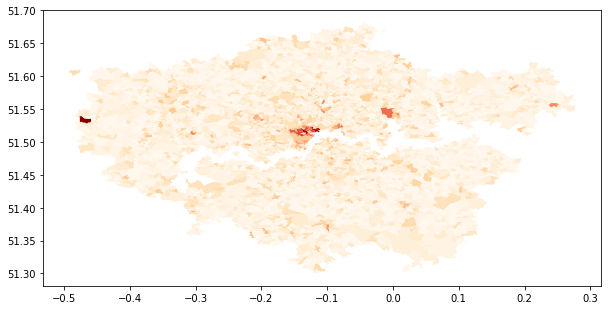

In [56]:
merged_data.plot(column='Sum of civic amenities', cmap='OrRd', figsize=(10,8))